# Plots of Predicstions vs. True Prices

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
# from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsRegressor

# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score

from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

import matplotlib.pyplot as plt
import random
# import re
# from rich import print
# from rich.table import Table
# from rich.console import Console
# import seaborn as sns

# console = Console()

## Loading Data

In [ ]:
# Defining the file paths of the train and test datasets
train_set = "data/final_train_data.csv"
test_set = "data/final_test_data.csv"

# Reading the Datasets into their respective Pandas Dataframes
train_data = pd.read_csv(train_set, header=0)
test_data = pd.read_csv(test_set, header=0)

# Dropping the 'Number' Column as it is surplus to requirements
train_data = train_data.drop('Number', axis=1)
test_data = test_data.drop('Number', axis=1)

# Storing all the features in a list of attributes
attributes = train_data.columns.tolist()

# Reorder the columns in test_data to match the column order of train_data
test_data = test_data[attributes]
true_vs_pred = [test_data.iloc[:, -1].copy().round(2)]


## Getting Predictions 

In [ ]:
def export_predictions(test_pred, model_name):
    # pred_file = f'predictions/{model_name}_pred.csv'
    # test_pred.to_csv(pred_file, index=False)

    # pred_file = f'predictions/{model_name}_pred.csv'

    # Convert NumPy array to pandas DataFrame
    pred_df = pd.DataFrame(test_pred, columns=['Predictions'])
    
    # Define the file path for saving the predictions
    pred_file = f'predictions/{model_name}_pred.csv'
    
    # Save DataFrame to CSV file
    pred_df.to_csv(pred_file, index=False)

## Feature Selection

In [ ]:
def ufs_feature_selection(train_data, n_features):
    # Initialize UFS
    selector = SelectKBest(score_func=f_regression, k=n_features)

    # Fit UFS to the training data
    selector.fit(train_data.iloc[:, :-1], train_data.iloc[:, -1])

    # Get selected features based on UFS
    selected_features = train_data.columns[selector.get_support(indices=True)]

    # Append the last column of the original dataset to selected features
    selected_features = list(selected_features) + [train_data.columns[-1]]

    return selected_features

selected_features = ufs_feature_selection(train_data, 28)
train_data = train_data[selected_features].copy()
test_data = test_data[selected_features].copy()

### 1-NN Base Model

In [ ]:
def nearest_neighbour_system_pred(train_data, test_data, k_neighbors):

    # Define the number of folds for cross-validation
    k = 5  # You can choose any value of k

    # Initialize the KFold splitter
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Iterate through each fold
    for train_index, val_index in kf.split(train_data):
        # Split data into training and testing sets
        train_df = train_data.iloc[train_index]

        # Optionally, reset the index of the new DataFrames
        train_df.reset_index(drop=True, inplace=True)
        # val_df.reset_index(drop=True, inplace=True)

        train_inputs = train_df.iloc[:, :-1].copy()
        train_labels = train_df.iloc[:, -1].copy()

        # val_inputs = val_df.iloc[:, :-1].copy()
        # val_labels = val_df.iloc[:, -1].copy().round(2)

        # Initialize the linear regression model
        model = KNeighborsRegressor(n_neighbors=k_neighbors)
        # Train the model
        model.fit(train_inputs, train_labels)

        # train_predictions = model.predict(train_inputs)
        # val_predictions = model.predict(val_inputs)

    test_inputs = test_data.iloc[:, :-1].copy()
    test_labels = test_data.iloc[:, -1].copy().round(2)

    predictions = model.predict(test_inputs)
    
    return predictions
    
    
one_nn_BM_pred = nearest_neighbour_system_pred(train_data, test_data, 1)
export_predictions(one_nn_BM_pred, '1_nn_BM')
true_vs_pred.append(one_nn_BM_pred)

### Linear Regression Base Model

In [ ]:
def linear_regression_system_pred(train_data, test_data):

    # Define the number of folds for cross-validation
    k = 5  # You can choose any value of k

    # Initialize the KFold splitter
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Iterate through each fold
    for train_index, val_index in kf.split(train_data):
        # Split data into training and testing sets
        train_df = train_data.iloc[train_index]

        # Optionally, reset the index of the new DataFrames
        train_df.reset_index(drop=True, inplace=True)
        # val_df.reset_index(drop=True, inplace=True)

        train_inputs = train_df.iloc[:, :-1].copy()
        train_labels = train_df.iloc[:, -1].copy()

        # val_inputs = val_df.iloc[:, :-1].copy()
        # val_labels = val_df.iloc[:, -1].copy().round(2)
        
        # Initialize the linear regression model
        model = LinearRegression()
        # Train the model
        model.fit(train_inputs, train_labels)


    test_inputs = test_data.iloc[:, :-1].copy()
    test_labels = test_data.iloc[:, -1].copy().round(2)

    predictions = model.predict(test_inputs)

    # Find the range of values in train_labels
    min_value = train_labels.min()
    max_value = train_labels.max()

    # Add tolerance of 20000 to the range
    min_value -= 5000
    max_value += 5000

    # Calculate the mean of all values in train_labels
    mean_value = train_labels.mean()

    # Replace values in predictions outside of the range (with tolerance) with the mean value
    predictions = np.where((predictions < min_value) | (predictions > max_value), mean_value, predictions)

    return predictions

lin_reg_BM_pred = linear_regression_system_pred(train_data, test_data)
export_predictions(lin_reg_BM_pred, 'lin_reg_BM')
true_vs_pred.append(lin_reg_BM_pred)

### Decision Tree Regression

In [ ]:
def decision_tree_regression_system_pred(train_data, test_data):

    # Define the number of folds for cross-validation
    k = 5  # You can choose any value of k

    # Initialize the KFold splitter
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Iterate through each fold
    for train_index, val_index in kf.split(train_data):
        # Split data into training and testing sets
        train_df = train_data.iloc[train_index]
        # Optionally, reset the index of the new DataFrames
        train_df.reset_index(drop=True, inplace=True)

        train_inputs = train_df.iloc[:, :-1].copy()
        train_labels = train_df.iloc[:, -1].copy()
        
        # Initialize the decision tree regression model
        model = DecisionTreeRegressor(random_state=42)  # You can adjust parameters if needed
        # Train the model
        model.fit(train_inputs, train_labels)

    test_inputs = test_data.iloc[:, :-1].copy()
    test_labels = test_data.iloc[:, -1].copy().round(2)

    predictions = model.predict(test_inputs)

    return predictions


dec_tree_pred = decision_tree_regression_system_pred(train_data, test_data)
export_predictions(dec_tree_pred, 'dec_tree')
true_vs_pred.append(dec_tree_pred)

### k-Nearest Neighbors

In [ ]:
knn_pred = nearest_neighbour_system_pred(train_data, test_data, 5)
export_predictions(knn_pred, 'kNN')
true_vs_pred.append(knn_pred)

### Multilayer Perceptron (MLP)

In [ ]:
def mlp_regression_system_pred(train_data, test_data):

    # Define the number of folds for cross-validation
    k = 5  # You can choose any value of k

    # Initialize the KFold splitter
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Iterate through each fold
    for train_index, val_index in kf.split(train_data):
        # Split data into training and testing sets
        train_df = train_data.iloc[train_index]

        # Optionally, reset the index of the new DataFrames
        train_df.reset_index(drop=True, inplace=True)

        train_inputs = train_df.iloc[:, :-1].copy()
        train_labels = train_df.iloc[:, -1].copy()
        
        # Initialize the MLP model
        model = MLPRegressor(hidden_layer_sizes=(120, 40), activation='relu', random_state=42)
        # Train the model
        model.fit(train_inputs, train_labels)

    
    test_inputs = test_data.iloc[:, :-1].copy()
    test_labels = test_data.iloc[:, -1].copy().round(2)

    predictions = model.predict(test_inputs)

    return predictions


mlp_pred = mlp_regression_system_pred(train_data, test_data)
export_predictions(mlp_pred, 'MLP')
true_vs_pred.append(mlp_pred)

### Radial Basis Function (RBF) Network

In [ ]:
def rbf_regression_system_pred(train_data, test_data):

    # Define the number of folds for cross-validation
    k = 5  # You can choose any value of k

    # Initialize the KFold splitter
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Iterate through each fold
    for train_index, val_index in kf.split(train_data):
        # Split data into training and testing sets
        train_df = train_data.iloc[train_index]

        # Optionally, reset the index of the new DataFrames
        train_df.reset_index(drop=True, inplace=True)
        

        train_inputs = train_df.iloc[:, :-1].copy()
        train_labels = train_df.iloc[:, -1].copy()

        # Create an RBF regression pipeline
        rbf_features = RBFSampler(gamma=0.1, n_components=100, random_state=42)  # Adjust gamma and n_components
        scaler = StandardScaler()
        ridge = Ridge(alpha=0.1)  # Adjust alpha (regularization strength)
        model = make_pipeline(rbf_features, scaler, ridge)

        # Train the model
        model.fit(train_inputs, train_labels)

    test_inputs = test_data.iloc[:, :-1].copy()
    test_labels = test_data.iloc[:, -1].copy().round(2)

    predictions = model.predict(test_inputs)

    return predictions


rbf_pred = rbf_regression_system_pred(train_data, test_data)
export_predictions(rbf_pred, 'RBF')
true_vs_pred.append(rbf_pred)

### Ridge Regression

In [ ]:
def ridge_regression_system(train_data, test_data):

    # Define the number of folds for cross-validation
    k = 5  # You can choose any value of k

    # Initialize the KFold splitter
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Iterate through each fold
    for train_index, val_index in kf.split(train_data):
        # Split data into training and testing sets
        train_df = train_data.iloc[train_index]

        # Optionally, reset the index of the new DataFrames
        train_df.reset_index(drop=True, inplace=True)

        train_inputs = train_df.iloc[:, :-1].copy()
        train_labels = train_df.iloc[:, -1].copy()
        
        # Initialize the linear regression model
        alpha = 1.0  # Regularization strength, you can adjust this value
        model = Ridge(alpha=alpha)
        # Train the model
        model.fit(train_inputs, train_labels)


    test_inputs = test_data.iloc[:, :-1].copy()
    test_labels = test_data.iloc[:, -1].copy().round(2)

    predictions = model.predict(test_inputs)

    return predictions


ridge_reg_pred = ridge_regression_system(train_data, test_data)
export_predictions(ridge_reg_pred, 'ridge_reg')
true_vs_pred.append(ridge_reg_pred)

### Support Vector Regression (SVR)

In [ ]:
def svr_system_pred(train_data, test_data):

    # Define the number of folds for cross-validation
    k = 5  # You can choose any value of k

    # Initialize the KFold splitter
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Iterate through each fold
    for train_index, val_index in kf.split(train_data):
        # Split data into training and testing sets
        train_df = train_data.iloc[train_index]

        # Optionally, reset the index of the new DataFrames
        train_df.reset_index(drop=True, inplace=True)
        # val_df.reset_index(drop=True, inplace=True)

        train_inputs = train_df.iloc[:, :-1].copy()
        train_labels = train_df.iloc[:, -1].copy()

        # Instantiate SVR model with best parameters
        model = SVR(kernel='rbf', C=10, gamma=0.01)

        # Train the model with the best parameters
        model.fit(train_inputs, train_labels)


    test_inputs = test_data.iloc[:, :-1].copy()
    test_labels = test_data.iloc[:, -1].copy().round(2)

    predictions = model.predict(test_inputs)

    return predictions

svr_pred = svr_system_pred(train_data, test_data)
export_predictions(svr_pred, 'SVR')
true_vs_pred.append(svr_pred)

### Trivial System

In [ ]:
class TrivialModel:
    def __init__(self, data):
        self.feature_data = data.iloc[:, :-1].copy()
        self.labels = data.iloc[:, -1].copy()
        self.labels = self.labels.round(2)

    def fit(self):
        self.output = self.labels.mean().round(2)

    def predict(self, user_input):
        return self.output


def trivial_system_pred(train_data, test_data, split):
    # Shuffle the DataFrame (optional but recommended)
    train_data = train_data.sample(frac=1).reset_index(drop=True)

    # Determine the size of the training set (e.g., 80%)
    train_size = split

    # Split the DataFrame into train and validation sets
    train_df = train_data.iloc[:int(len(train_data) * train_size)]

    # Optionally, reset the index of the new DataFrames
    train_df.reset_index(drop=True, inplace=True)

    test_inputs = test_data.iloc[:, :-1].copy()
    test_labels = test_data.iloc[:, -1].copy().round(2)

    model = TrivialModel(train_df)
    model.fit()

    predictions = []


    for _, data_pt in test_inputs.iterrows():
        output = model.predict(data_pt)
        predictions.append(output)

    return predictions


training_splits = [0.85]

for split in training_splits:
    trivial_sys_pred = trivial_system_pred(train_data, test_data, split)
    split_str = str(int(split*100))
    export_predictions(trivial_sys_pred, f'trivial_sys_{split_str}')
    true_vs_pred.append(trivial_sys_pred)


## Load Predictions

In [ ]:
filenames = ['1_nn_BM_pred.csv', 'lin_reg_BM_pred.csv', 'dec_tree_pred.csv', 'kNN_pred.csv',
             'MLP_pred.csv', 'RBF_pred.csv', 'ridge_reg_pred.csv', 'SVR_pred.csv', 'trivial_sys_50_pred.csv',
             'trivial_sys_60_pred.csv', 'trivial_sys_70_pred.csv', 'trivial_sys_80_pred.csv',
             'trivial_sys_85_pred.csv']

# List to store the data from each CSV file
data_list = [test_data.iloc[:, -1].copy().round(2)]

# Iterate over each file in the directory
for filename in filenames:
    data = pd.read_csv(f'predictions/{filename}', header=None, index_col=None, skiprows = 1)
    # Extract the column containing the data
    data_column = data.iloc[:, 0]

    # Convert the column to a list
    data_check = data_column.tolist()
    # Extract the values as a Series and then convert it to a list
    data_list.append(data_check)



## Plot

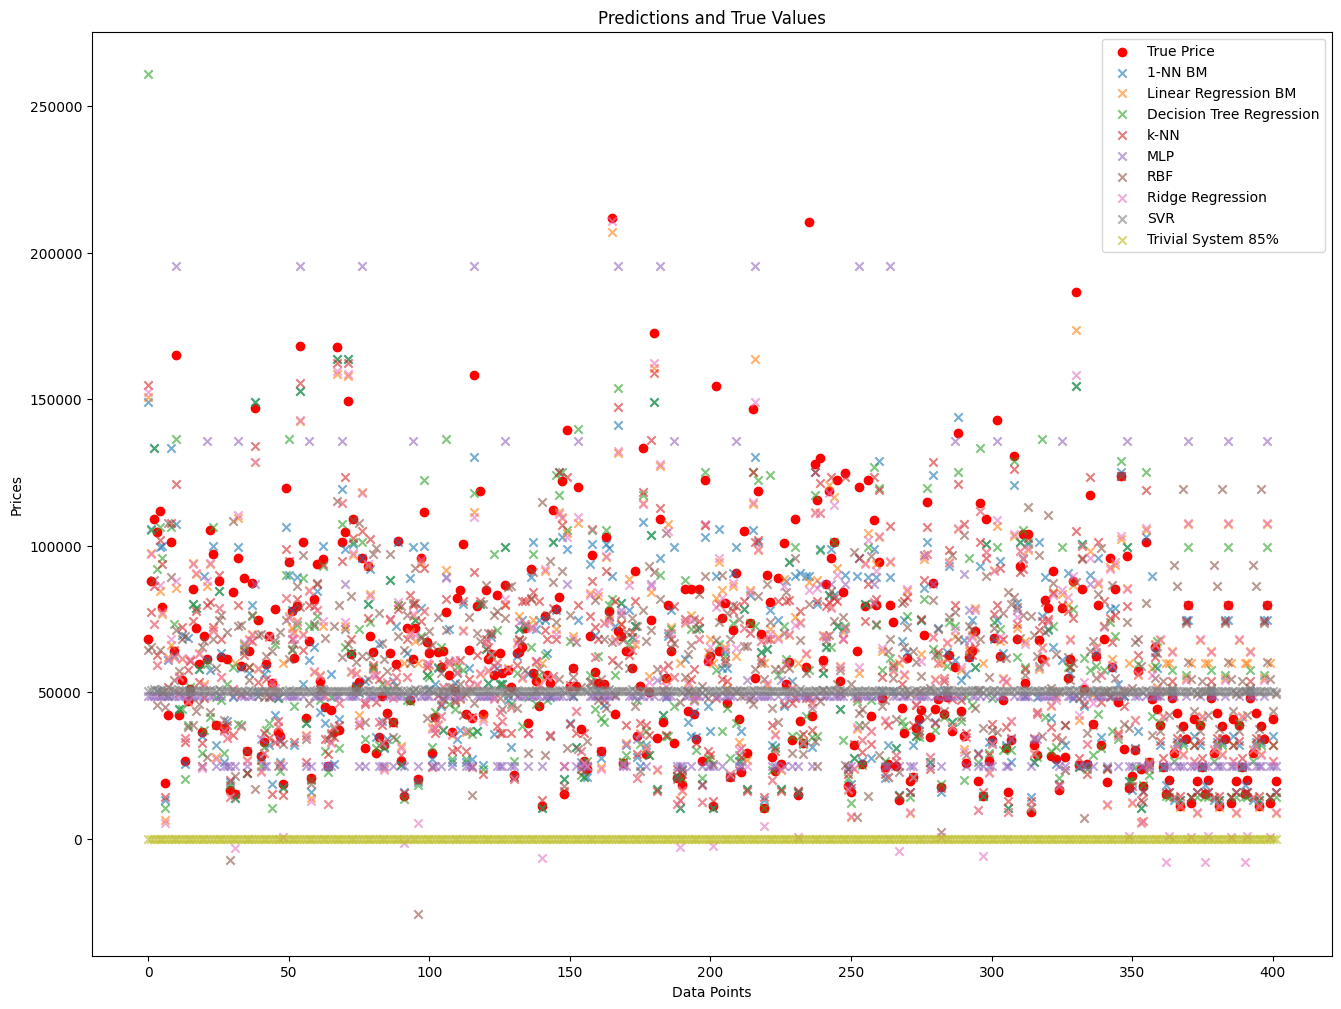

In [ ]:
def plot_predictions_scatter(model_names, true_vs_pred):
    plt.figure(figsize=(16,12))
    
    x_vals = range(len(true_vs_pred[0]))
    # Plot predictions for each model
    for model_name, y_vals in zip(model_names, true_vs_pred):
        if model_name == 'True Price':
            plt.scatter(x_vals, y_vals, alpha=1, label=model_name, marker='o', color = 'red')
        else:
            plt.scatter(x_vals, y_vals, alpha=0.6, label=model_name, marker = 'x')

    
    plt.xlabel('Data Points')
    plt.ylabel('Prices')
    plt.title('Predictions and True Values')
    plt.legend()
    plt.show()


model_names = ['True Price', '1-NN BM', 'Linear Regression BM', 'Decision Tree Regression', 'k-NN', 'MLP', 'RBF', 'Ridge Regression', 'SVR', 'Trivial System 85%']

# Assuming models_predictions_dict is a dictionary where keys are model names and values are arrays or pandas Series of predictions
plot_predictions_scatter(model_names, data_list)


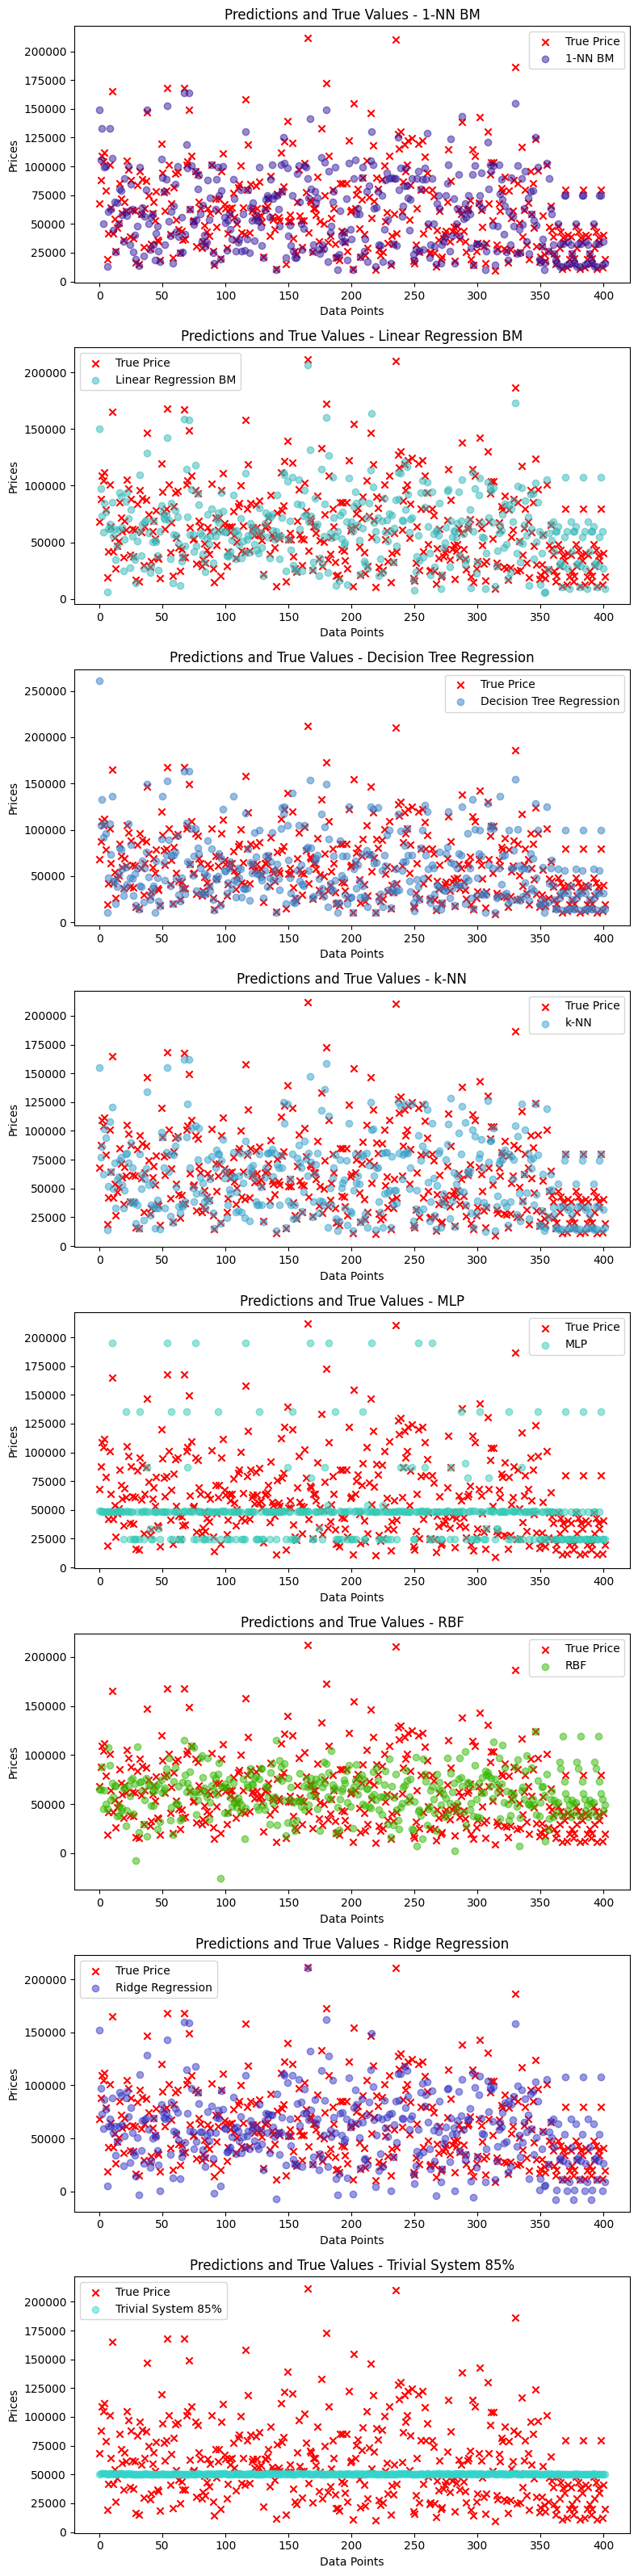

In [ ]:
def plot_predictions_scatter(model_names, true_vs_pred):
    num_models = len(model_names)-1
    fig, axes = plt.subplots(nrows=num_models, ncols=1, figsize=(8, 4*num_models))
    
    for i, (model_name, y_vals) in enumerate(zip(model_names[1:], true_vs_pred[1:])):
        color = [0.2, random.random(), random.random()]  # Random RGB color

        ax = axes[i]
        ax.scatter(range(len(y_vals)), true_vs_pred[0], alpha=1, label=model_names[0], marker = 'x', color = 'red')
        ax.scatter(range(len(y_vals)), y_vals, alpha=0.5, label=model_name, color=color)
        ax.set_xlabel('Data Points')
        ax.set_ylabel('Prices')
        ax.set_title(f'Predictions and True Values - {model_name}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage
model_names = ['True Price', '1-NN BM', 'Linear Regression BM', 'Decision Tree Regression', 
               'k-NN', 'MLP', 'RBF', 'Ridge Regression', 'Trivial System 85%']

plot_predictions_scatter(model_names, data_list)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9992d859-d1f8-4007-afdd-e66541c42881' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>